In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = '../../data/tp53_data'
output_dir = './plots'

# TP53 mutations

In [3]:
table_file = os.path.join(data_dir,'TP53_merged_data.tsv')

In [10]:
table = pd.read_csv(table_file,sep='\t')

# only keep those sites with a experimental saturation value
print(table.shape)
table = table[~(table["experimental_score"].isna())].reset_index()
print(table.shape)

(3984, 26)
(1920, 27)


In [11]:
table['consequence_normal'].value_counts()

consequence_normal
missense                 234
synonymous                16
nonsense                  15
essential_splice          12
splice_region_variant      9
intron_variant             4
Name: count, dtype: int64

In [12]:
def group_normal_consequence(r):
    if r['consequence_normal'] == 'missense':
        return 'missense'
    elif r['consequence_normal'] == 'nonsense' or r['consequence_normal'] == 'essential_splice':
        return 'truncating'
    elif r['consequence_normal'] == 'synonymous':
        return 'synonymous'
    elif r['consequence_normal'] == 'intron_variant' or r['consequence_normal'] == 'non_coding_exon_region':
        return 'noncoding'
    elif r['consequence_normal'] == 'splice_region_variant':
        return 'other'
    else:
        return 'not_observed'

In [13]:
table['consequence_normal_formatted'] = table.apply(group_normal_consequence,axis=1)

In [14]:
table['consequence_normal_formatted'].value_counts()

consequence_normal_formatted
not_observed    1630
missense         234
truncating        27
synonymous        16
other              9
noncoding          4
Name: count, dtype: int64

In [15]:
list(table.columns)

['index',
 'chr',
 'pos',
 'ref',
 'alt',
 'consequence_intogen',
 'count_intogen_cancer',
 'count_intogen_bladder',
 'consequence_genie',
 'count_genie',
 'freq_genie',
 'count_bladder_genie',
 'freq_bladder_genie',
 'boostdm_score_cancer',
 'boostdm_class_cancer',
 'boostdm_score_bladder',
 'boostdm_class_bladder',
 'oncogenic',
 'consequence_normal',
 'count_normal',
 'experimental_score',
 'p_value_experimental',
 'freq_intogen_cancer',
 'freq_intogen_bladder',
 'freq_normal',
 'site_selection',
 'p_value',
 'consequence_normal_formatted']

In [16]:
def group(r):
    if r['consequence_normal_formatted'] == 'not_observed':
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'
    

In [17]:
table['group_normal'] = table.apply(group,axis=1)

In [18]:
table['oncogenic'] = table['oncogenic'].fillna(0)
oncogenic_data = table.groupby(['group_normal','oncogenic'])['chr'].count().reset_index().pivot(index='group_normal',columns='oncogenic',values='chr').reset_index()
oncogenic_values = oncogenic_data.to_dict()
oncogenic_data['N'] = oncogenic_data[0.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data['Y'] = oncogenic_data[1.0] / (oncogenic_data[0.0] + oncogenic_data[1.0])
oncogenic_data = oncogenic_data.drop([0.0,1.0],axis=1)

In [19]:
oncogenic_values

{'group_normal': {0: 'not_observed', 1: 'not_significant', 2: 'significant'},
 0.0: {0: 960.0, 1: 50.0, 2: nan},
 1.0: {0: 670.0, 1: 213.0, 2: 23.0}}

In [20]:
table['group_normal'].value_counts()

group_normal
not_observed       1630
not_significant     263
significant          23
Name: count, dtype: int64

In [21]:
table.groupby(by='group_normal')['freq_intogen_bladder'].mean()

group_normal
not_observed       0.000100
not_significant    0.000439
significant        0.005316
Name: freq_intogen_bladder, dtype: float64

# site selection groups as independent variable

In [22]:
size_groups = pd.DataFrame({'size':table.groupby(by='group_normal')['chr'].count()}).reset_index()

In [23]:
size_groups

,group_normal,size
0,not_observed,1630
1,not_significant,263
2,significant,23


In [24]:
# Define the custom color palette
custom_palette = {
    'significant': 'blue',       # Blue for significant
    'not_significant': '#6baed6',  # Lighter blue for not significant
    'not_observed': 'gray'       # Gray for not observed
}


/tmp/ipykernel_4100815/219116185.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(axs.get_yticklabels(), fontsize = 10)


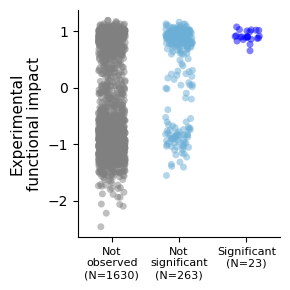

In [28]:
TP53_experimental_saturation_figure = os.path.join(output_dir,'Fig5d_TP53_experimental_saturation_fig.png')


# Create the plot
fig, axs = plt.subplots(1, 1, figsize=(3,3), sharex=True)

sns.stripplot(data=table,
              x='group_normal',
              y='experimental_score',
              jitter=0.2,
              hue='group_normal',
              alpha=0.5,
              edgecolor='none',
              linewidth=1,
              hue_order= ['significant', 'not_significant', 'not_observed'],
              palette=custom_palette,  # Apply the custom palette
              ax=axs)

axs.get_legend().remove()
axs.set_ylabel('Experimental\nfunctional impact', fontsize = 11)
axs.set_xlabel('')

axs.set_xticks([0,1,2],
               ['Not\nobserved\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_observed']['size'].values[0]) + ')',
                'Not\nsignificant\n(N=' + str(size_groups[size_groups['group_normal'] == 'not_significant']['size'].values[0]) + ')',
                'Significant\n(N=' + str(size_groups[size_groups['group_normal'] == 'significant']['size'].values[0]) + ')'],
               rotation = 0, 
               fontsize = 8
            #    rotation='vertical'
               )

axs.set_yticklabels(axs.get_yticklabels(), fontsize = 10)
axs.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(TP53_experimental_saturation_figure, dpi = 300)
plt.show()
